# Тема "Иерархические методы"

Иерархические методы сводятся к построению иерархических структур, самой простой из которых явлеятся древовидная. Далее мы рассмотрим реализацию дерева решений.

In [1]:
import pandas as pd #импорт библиотек, которые потребуются.
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from IPython.display import Image

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18,12)

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

В любом дереве решений можно выделить 3 типа вершин:
1. Корневая вершина (root node) -  из нее начинается построение дерева;
2. Внутренние вершины (intermediate nodes) - в них происходит движение по дереву, в зависимости от условий;
3. Листья (leafs) - самые глубокие вершины дерева, в которых содержится "ответ".

Во внутренней или корневой вершине признак проверяется на некий логический критерий, по результатам которого мы движемся все глубже.

#### Преимущества и недостатки деревьев решений:

** Преимущества **
* Простота построения
* Интерпретируемость (при небольшой глубине)
* Требуются минимальная предобработка признаков
* Встроенный отбор признаков



** Недостатки **
* Границы строятся только параллельно или перпендикулярно осям
* При изменении набора данных, дерево необходимо полностью перестраивать и результат может получится совершенно иным
* Жадность построения

In [2]:
df_churn = pd.read_csv('Модуль 2_Тема 2. Отток.csv') # загрузим данные из файла (данные по оттоку клиентов)

In [3]:
df_churn.head() #Посмотрим на наши данные, видно, что они нуждаются в обработке.

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [4]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

Признаки "Int'l Plan", "VMail Plan" и "Churn?" принимают значения в пределах дихотомической шкалы.
Следовательно их можно привести к виду "0" и "1." Сделаем это при помощи функции "preproc".

In [5]:
def preproc(df_init): #объявляем функцию
    df_preproc = df_init.copy()
    
    df_preproc = df_preproc.drop(['State', 'Area Code', 'Phone'], axis=1) # удаляем малоинформативные столбцы
    
    df_preproc.loc[:,  ["Int'l Plan", 'VMail Plan']] = \
    df_preproc.loc[:,  ["Int'l Plan", 'VMail Plan']].replace({'no': 0, 'yes': 1}) # делаем замену значений в указанных столбцах
                                                                                  # на 0 и 1
    df_preproc.loc[:,  'Churn?'] = df_preproc.loc[:,  'Churn?'].replace({'False.': 0, # аналогично делаем замену и в столбце 'Churn?'
                                                                         'True.': 1})
    return df_preproc

In [6]:
df_preproc = df_churn.pipe(preproc) # обрабоатываем датафрейм при помощи функции, описанной выше.
df_preproc.info() # смотрим на наши данные - пропусков нет, и среди данных только числовые значения.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account Length  3333 non-null   int64  
 1   Int'l Plan      3333 non-null   int64  
 2   VMail Plan      3333 non-null   int64  
 3   VMail Message   3333 non-null   int64  
 4   Day Mins        3333 non-null   float64
 5   Day Calls       3333 non-null   int64  
 6   Day Charge      3333 non-null   float64
 7   Eve Mins        3333 non-null   float64
 8   Eve Calls       3333 non-null   int64  
 9   Eve Charge      3333 non-null   float64
 10  Night Mins      3333 non-null   float64
 11  Night Calls     3333 non-null   int64  
 12  Night Charge    3333 non-null   float64
 13  Intl Mins       3333 non-null   float64
 14  Intl Calls      3333 non-null   int64  
 15  Intl Charge     3333 non-null   float64
 16  CustServ Calls  3333 non-null   int64  
 17  Churn?          3333 non-null   i

In [7]:
X, y = df_preproc.iloc[:, :-1].values, df_preproc.iloc[:, -1].values # разделяем датафрейм на два множества:
# данные для обучения и ответы.

## Кросс-валидация по одному гиперпараметру

Посмотрим, как работает функция `validation_curve`.

In [8]:
try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

try:
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import StratifiedKFold

`validation_curve` позволяет исследовать влияние отдельного гиперпараметра модели на ее качество.

Построим валидационные кривые по гиперпараметру глубина дерева (`max_depth`) при остальных гиперпараметрах, зафиксированных на значениях по-умолчанию

In [9]:
from sklearn.tree import DecisionTreeClassifier #импортируем модель деревьев решений
model = DecisionTreeClassifier(random_state=123) # инициализируем модель

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=132) #разбиваем наше множество на 5 частей и перемешиваем "shuffle=True"

train_scores, valid_scores = validation_curve(model, X, y,       #задаем параметры для валидационной кривой.
                                              'max_depth', range(1, 20), # будем исследовать глубину дерева в диапазоне от 1 до 20
                                              cv=cv, scoring='roc_auc')

In [10]:
train_scores.shape

(19, 5)

In [11]:
valid_scores.shape

(19, 5)

Text(0, 0.5, 'ROC AUC')

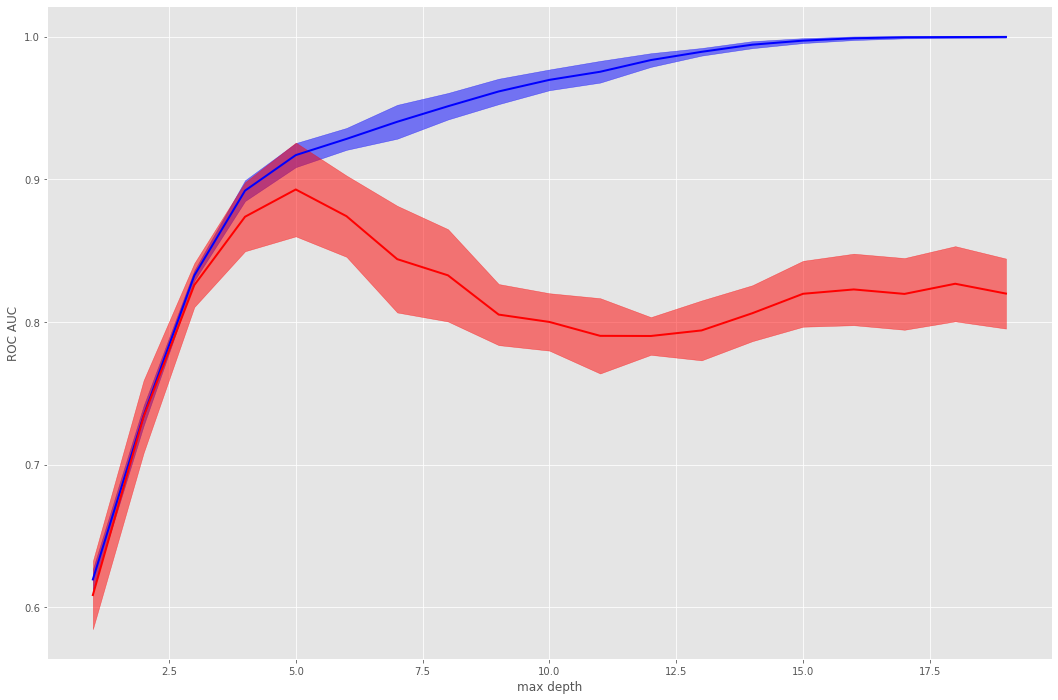

In [12]:
train_score_mean = train_scores.mean(axis=1)
train_score_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)

plt.fill_between(range(1,20), train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                 interpolate=True, alpha=0.5,)
plt.fill_between(range(1,20), valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
                 interpolate=True, alpha=0.5)

plt.plot(range(1,20), train_score_mean, c='b', lw=2)
plt.plot(range(1,20), valid_scores_mean, c='r', lw=2)

plt.xlabel('max depth')
plt.ylabel('ROC AUC')

На рисунке показана зависимость метрики качества ROC AUC от глубины древа. Синяя кривая - значение метрики на обучающем множестве и при увеличении глубины значение ROC AUC приближается к 1, то есть модель правильно классифицирует все объекты обучающего множества. Красная кривая - значение ROC AUC на тестовом множестве и наилучший результат на этом множестве, то есть максимальное значение ROC AUC наблюдается при глубине дерева 5. Следовательно это оптимальное значение глубины. 
Данное значение мы рассчитали без привязки к другим параметрам.

## Подбор всех гиперпараметров

Обычно подбирают гиперпараметры целыми группами. Это делается для того чтобы ускорить процедуру поиска и сразу найти оптимальное сочетание параметров. Есть несколько способов это сделать:
* Полный перебор (Grid Search) - явно задаются все возможные значения параметров. Далее перебираются все возможные комбинации этих параметров
* Случайный перебор (Random Search) - для некоотрых параметров задается распределение через функцию распределения. Задается количество случайных комбинаций, которых требуется перебрать.

<center><img src='https://cdn-images-1.medium.com/max/800/1*ZTlQm_WRcrNqL-nLnx6GJA.png'></center>

In [13]:
try:
    from sklearn.model_selection import RandomizedSearchCV #импортирует случайный поиск
except ImportError:
    from sklearn.cross_validation import RandomizedSearchCV
    
RND_SEED = 123

In [14]:
param_grid = {                                 #зададим параметры по которым и будем осуществлять поиск
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2, 8),
    'min_samples_leaf': range(5, 10),
    'class_weight': [None, 'balanced']}

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

model = DecisionTreeClassifier(random_state=123)
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, n_jobs=-1,
                                   cv=cv, scoring='roc_auc', random_state=123)

random_search.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=123),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'class_weight': [None, 'balanced'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 8),
                                        'min_samples_leaf': range(5, 10)},
                   random_state=123, scoring='roc_auc')

In [15]:
random_search.best_params_ #выведем наилучшие параметры

{'min_samples_leaf': 8,
 'max_depth': 5,
 'criterion': 'entropy',
 'class_weight': None}

In [16]:
random_search.best_score_ #лучшее значение метрики

0.8916229012178212

In [17]:
best_model = random_search.best_estimator_;
best_model #параметры наилучшей модели

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=8,
                       random_state=123)

## Важность признаков

Возьмем лучшую модель и выведем для нее важность признаков

In [18]:
model = random_search.best_estimator_
imp = model.feature_importances_

Каждое число соответствует важности признака, который подавался на вход

Для каждого признака (с названием) получим его значение важности

In [19]:
pd.Series(index=df_preproc.columns[:-1], data = imp).sort_values()

Account Length    0.000000
Intl Charge       0.000000
Day Calls         0.000000
Eve Calls         0.000000
VMail Message     0.000000
Night Calls       0.003033
Night Mins        0.015052
Night Charge      0.016540
VMail Plan        0.044805
Eve Charge        0.054604
Eve Mins          0.061566
Intl Calls        0.072658
Intl Mins         0.107815
Day Charge        0.136850
Int'l Plan        0.144571
CustServ Calls    0.163178
Day Mins          0.179328
dtype: float64